In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

import squarify
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
df = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

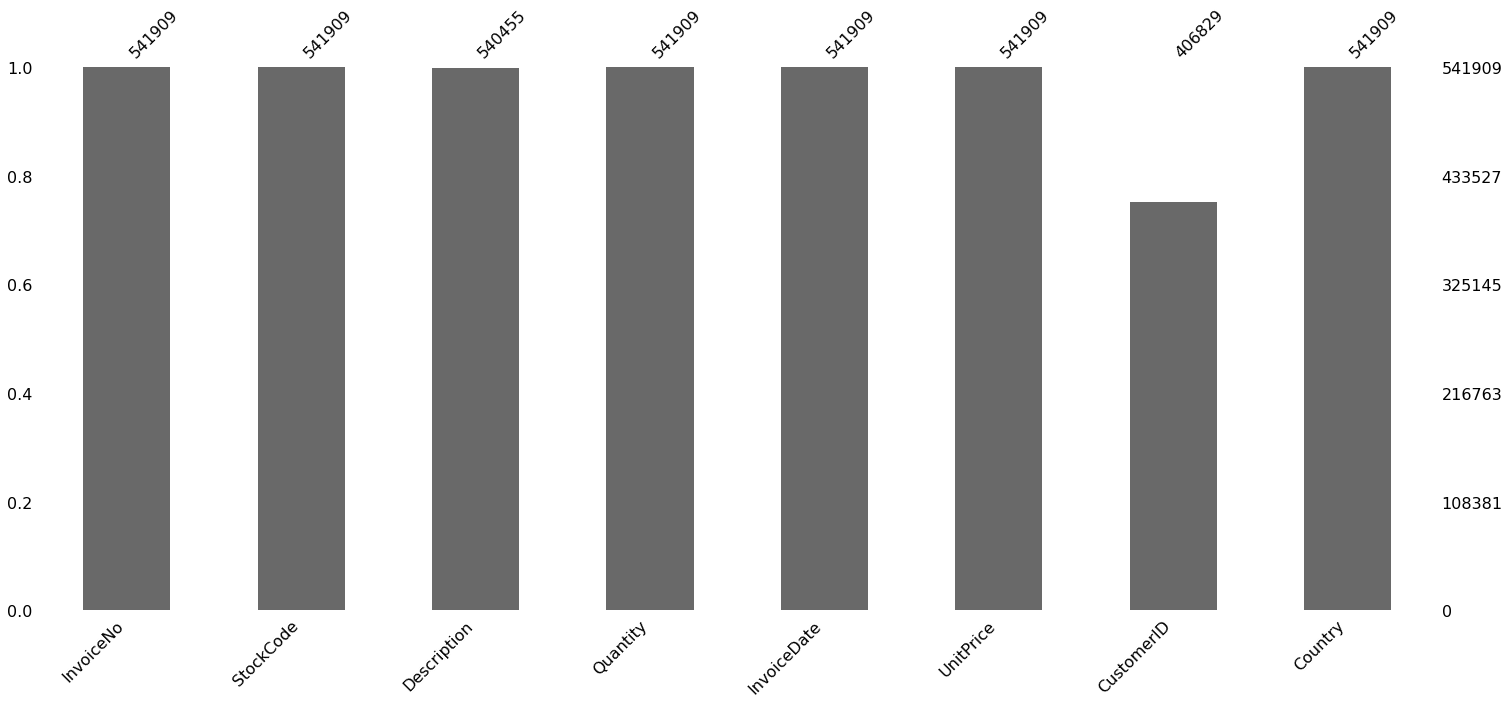

In [4]:
import missingno as msno
msno.bar(df)

In [6]:
df = df.dropna()
df.shape

(406829, 8)

<AxesSubplot:>

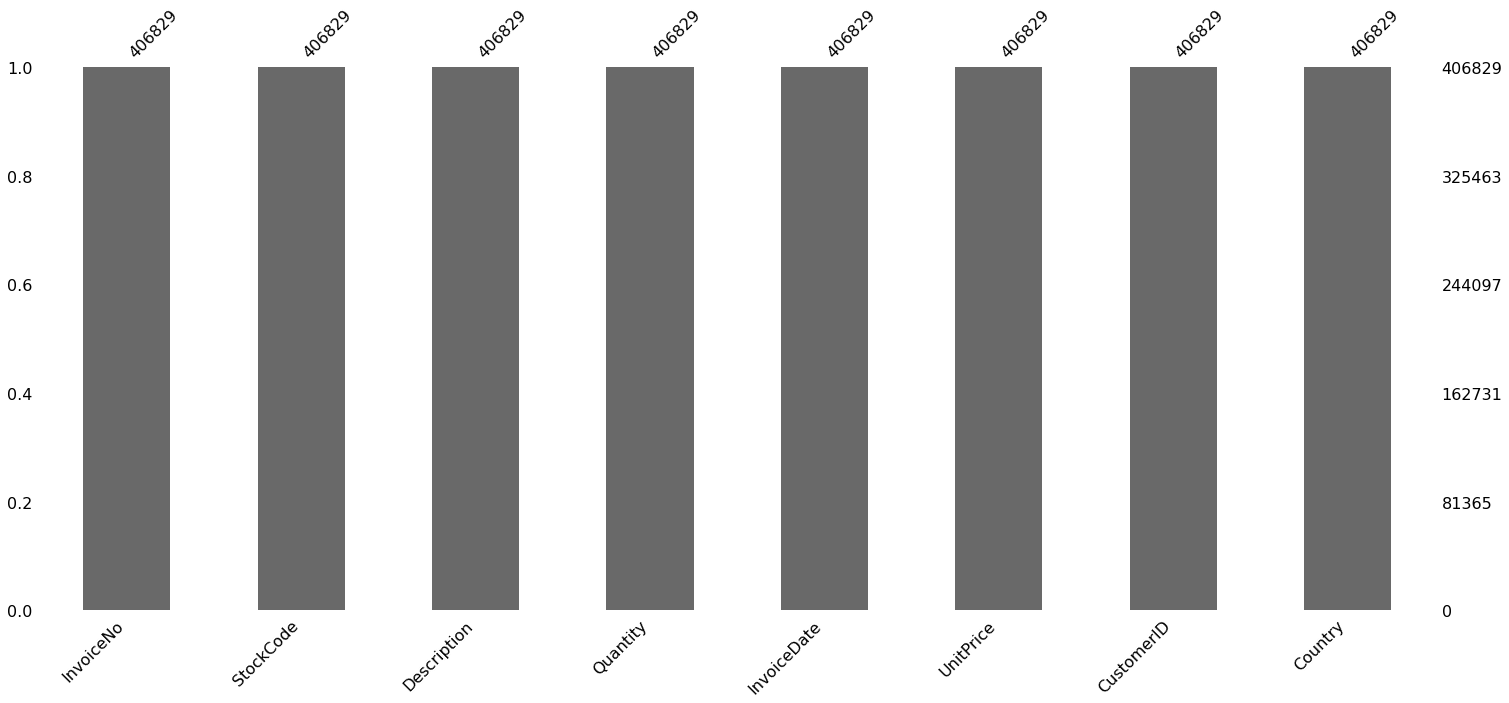

In [7]:
msno.bar(df)

In [9]:
#checking for duplicates
df.duplicated().sum()

5225

In [10]:
#removing duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(401604, 8)

In [12]:
retail = df.copy()

In [13]:
#calculate revenue per row and add new column
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

In [14]:
retail.InvoiceDate = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

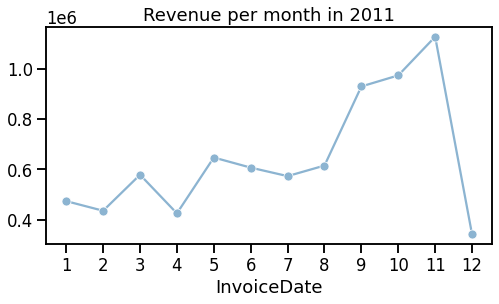

In [15]:
# Let's visualize the top grossing months
retail_month = retail[retail.InvoiceDate.dt.year==2011]
monthly_gross = retail_month.groupby(retail_month.InvoiceDate.dt.month).Revenue.sum()

plt.figure(figsize=(8,4))
sns.set_context("talk")
sns.set_palette("PuBuGn_d")
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o')
plt.xticks(range(1,13))
plt.title("Revenue per month in 2011")
plt.show()

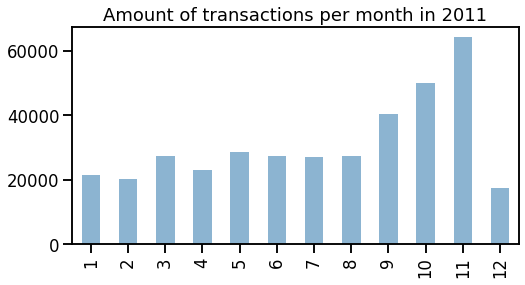

In [16]:
#amount of transactions per month
plt.figure(figsize=(8,4))
retail[retail.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.show()

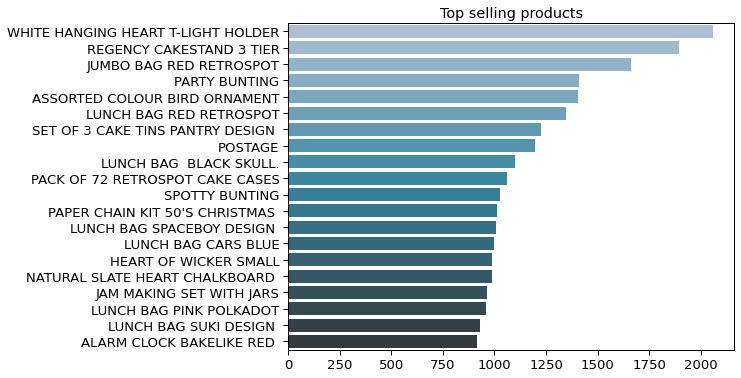

<Figure size 432x288 with 0 Axes>

In [17]:
# Let's visualize some top products from the whole range
top_products = retail['Description'].value_counts()[:20]
plt.figure(figsize=(8,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values, 
           palette='PuBuGn_d')
plt.title("Top selling products")
plt.show()
plt.savefig('top_products.png')

# Data Preparation - RFM Model

In [19]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
#let's look at amount spend per customer (revenue contributed) M-Monetary
retail_mv = retail.groupby(['CustomerID']).agg({'Amount': sum}).reset_index()
retail_mv.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [20]:
#F-frequency (how many purchases each customer made)
retail_f = retail.groupby('CustomerID')['InvoiceNo'].count()
retail_f = retail_f.reset_index()
retail_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [21]:
#R-recency 
#last transaction date 

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(retail['InvoiceDate'])

#difference between last date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00


In [22]:
#merge previous dataframes together (mv+f)
retail_mv_f = pd.merge(retail_mv, retail_f, on='CustomerID', how='inner')
retail_mv_f.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [23]:
#recency per customer (last transaction date)
retail_r = retail.groupby('CustomerID')['Diff'].min()
retail_r = retail_r.reset_index()

# Extract number of days only
retail_r['Diff'] = retail_r['Diff'].dt.days

In [24]:
#merge R dataframe with FM

retail_rfm = pd.merge(retail_mv_f, retail_r, on='CustomerID', how='inner')
retail_rfm.columns = ['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [25]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(retail_rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(retail_rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(retail_rfm.MonetaryValue, q = 4, labels = m_labels)

In [26]:
# make a new column for group labels
retail_rfm['R'] = r_groups.values
retail_rfm['F'] = f_groups.values
retail_rfm['M'] = m_groups.values
# sum up the three columns
retail_rfm['RFM_Segment'] = retail_rfm.apply(lambda x: str(int(x['R'])) + str(int(x['F'])) + str(int(x['M'])), axis = 1)
retail_rfm['RFM_Score'] = retail_rfm[['R', 'F', 'M']].sum(axis = 1)
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score
0,12346.0,0.00,2,325,1,1,1,111,3
1,12347.0,4310.00,182,1,4,4,4,444,12
2,12348.0,1797.24,31,74,2,2,4,224,8
3,12349.0,1757.55,73,18,3,3,4,334,10
4,12350.0,334.40,17,309,1,1,2,112,4


In [27]:
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(retail_rfm.RFM_Score, q = 4, labels = score_labels)
retail_rfm['RFM_Level'] = score_groups.values
retail_rfm.sort_values(by='RFM_Score', ascending=False)
retail_rfm.head(10)

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,12346.0,0.00,2,325,1,1,1,111,3,Green
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver
4,12350.0,334.40,17,309,1,1,2,112,4,Green
5,12352.0,1545.41,95,35,3,3,3,333,9,Silver
6,12353.0,89.00,4,203,1,1,1,111,3,Green
7,12354.0,1079.40,58,231,1,3,3,133,7,Bronze
8,12355.0,459.40,13,213,1,1,2,112,4,Green
9,12356.0,2811.43,59,22,3,3,4,334,10,Silver


In [28]:
retail_rfm_levels = retail_rfm.groupby('RFM_Level')['CustomerID'].count().reset_index(name='counts')
retail_rfm_levels.head()

,RFM_Level,counts
0,Green,1298
1,Bronze,908
2,Silver,1322
3,Gold,844


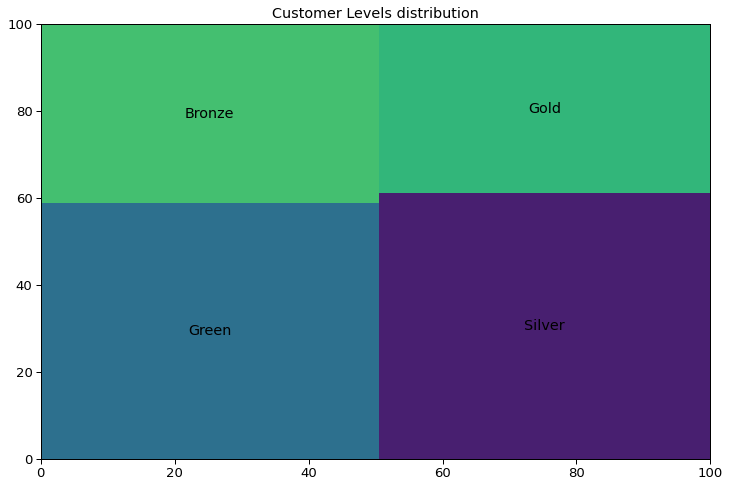

In [29]:
#let's exclude others segment for visualization
levels = list(retail_rfm_levels.RFM_Level)
score = list(retail_rfm_levels.counts)
plt.figure(figsize=(12,8))
plt.title('Customer Levels distribution')
squarify.plot(sizes=score, label=levels)

plt.show()

In [30]:
#let's try to do more detailed segmentation
segment_dict = {    
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [31]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

# Allocate segments to each customer as per the RFM score mapping
retail_rfm['Segment'] = retail_rfm.RFM_Segment.map(lambda x: dict_segment.get(x))

In [32]:
# Allocate all remaining customers to others segment category
retail_rfm.Segment.fillna('others', inplace=True)

In [33]:
retail_rfm.sample(10)

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment
1930,14965.0,596.09,81,95,2,3,2,232,7,Bronze,others
1287,14078.0,1049.37,65,101,2,3,3,233,8,Silver,others
3954,17711.0,385.10,23,10,4,2,2,422,8,Silver,others
2387,15572.0,2533.42,212,4,4,4,4,444,12,Gold,Best Customers
2989,16387.0,94.36,4,322,1,1,1,111,3,Green,others
1239,14014.0,505.18,39,76,2,2,2,222,6,Bronze,others
1106,13829.0,-102.00,1,358,1,1,1,111,3,Green,others
3952,17708.0,263.33,34,187,1,2,1,121,4,Green,others
600,13132.0,77.30,3,261,1,1,1,111,3,Green,others
1342,14152.0,611.09,50,74,2,3,2,232,7,Bronze,others


In [34]:
retail_rfm_segments = retail_rfm[retail_rfm.Segment!='other'].groupby('Segment')['CustomerID'].count().reset_index(name='counts')
retail_rfm_segments.iloc[:8]

,Segment,counts
0,At Risk Customers,105
1,Best Customers,470
2,Big Spenders,57
3,Can’t Lose Them,21
4,Lost Cheap Customers,204
5,Loyal Customers,210
6,Potential Loyalists,79
7,Recent Customers,85


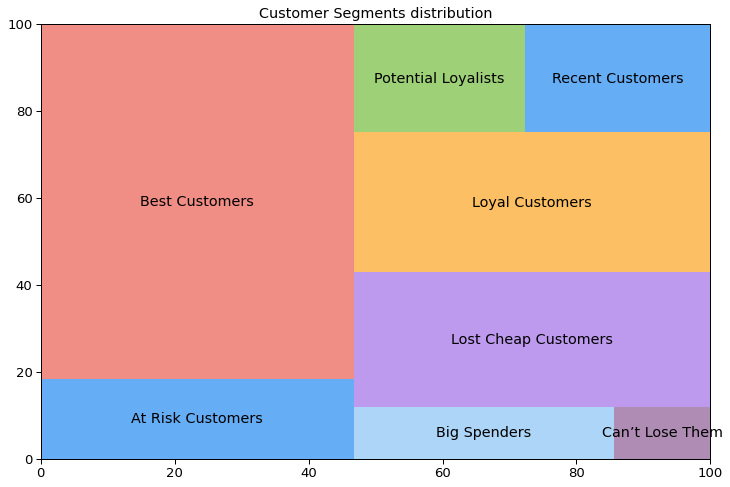

In [35]:
#let's exclude others segment for visualization
segment = list(retail_rfm_segments.iloc[:8].Segment)
score = list(retail_rfm_segments.iloc[:8].counts)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]
plt.figure(figsize=(12,8))
plt.title('Customer Segments distribution')
squarify.plot(sizes=score, label=segment,color=color_list, alpha=0.7)

plt.show()

Text(0.5, 0, 'Attributes')

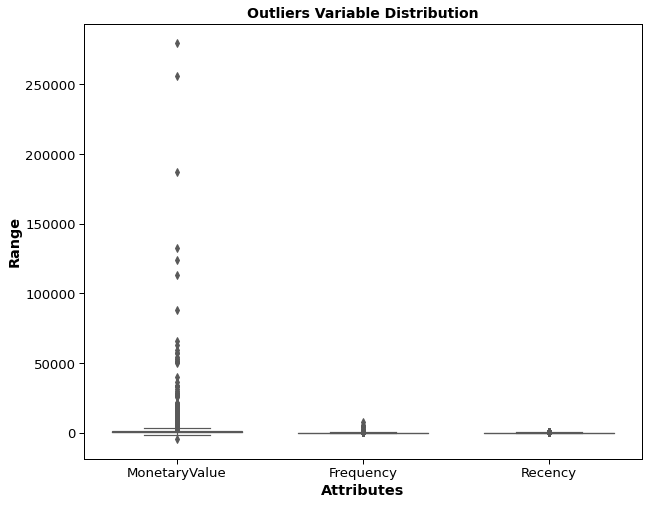

In [37]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['MonetaryValue','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = retail_rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [40]:
# Removing (statistical) outliers for Amount
Q1 = retail_rfm.MonetaryValue.quantile(0.05)
Q3 = retail_rfm.MonetaryValue.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.MonetaryValue >= Q1 - 1.5*IQR) & (retail_rfm.MonetaryValue <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = retail_rfm.Recency.quantile(0.05)
Q3 = retail_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.Recency >= Q1 - 1.5*IQR) & (retail_rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = retail_rfm.Frequency.quantile(0.05)
Q3 = retail_rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.Frequency >= Q1 - 1.5*IQR) & (retail_rfm.Frequency <= Q3 + 1.5*IQR)]

In [41]:
# Rescaling the attributes

retail_rfm_df = retail_rfm[['MonetaryValue', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
retail_rfm_scaled = scaler.fit_transform(retail_rfm_df)
retail_rfm_scaled.shape

(4295, 3)

In [42]:
retail_rfm_scaled = pd.DataFrame(retail_rfm_scaled)
retail_rfm_scaled.columns = ['MonetaryValue', 'Frequency', 'Recency']
retail_rfm_scaled.head()

,MonetaryValue,Frequency,Recency
0,-0.722542,-0.750830,2.302166
1,1.735232,1.057112,-0.906150
2,0.302333,-0.459551,-0.183289
3,0.279700,-0.037698,-0.737813
4,-0.531850,-0.600168,2.143731


# K Means Clustering Algorithm

In [44]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(retail_rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

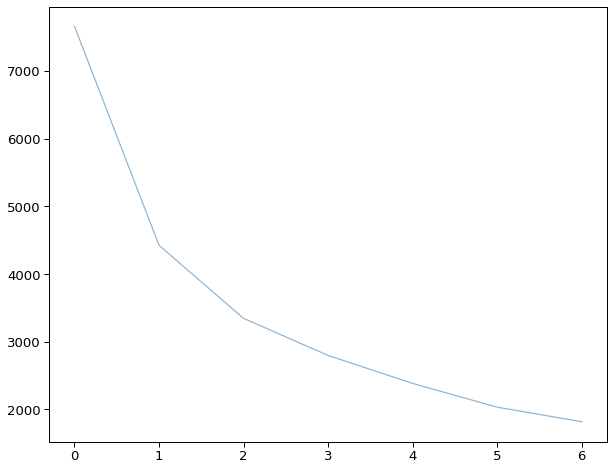

In [45]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(retail_rfm_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Text(0.5, 1.0, 'Error Rate and Clusters')

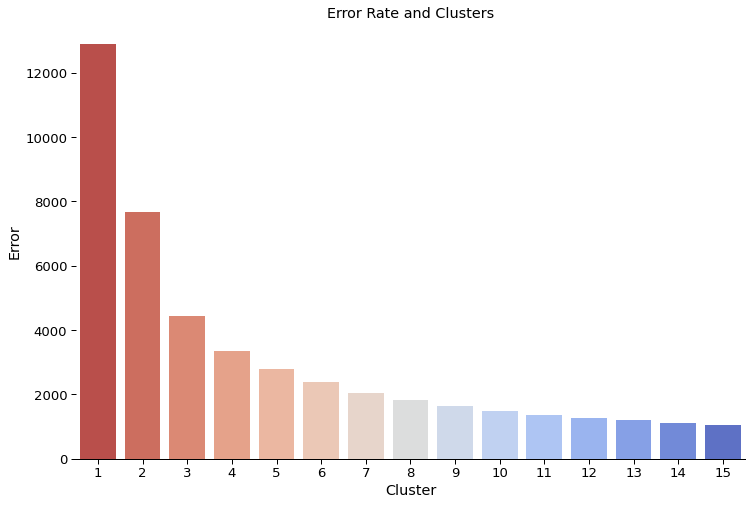

In [46]:
error_rate = []
for clusters in range(1,16):
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(retail_rfm_scaled)
    kmeans.predict(retail_rfm_scaled)
    error_rate.append(kmeans.inertia_)
    
error_rate = pd.DataFrame({'Cluster':range(1,16) , 'Error':error_rate})
plt.figure(figsize=(12,8))
p = sns.barplot(x='Cluster', y= 'Error', data= error_rate, palette='coolwarm_r')
sns.despine(left=True)
p.set_title('Error Rate and Clusters')

In [47]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(retail_rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [49]:
# assign the label
retail_rfm['Cluster_Id'] = kmeans.labels_
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id
0,12346.0,0.00,2,325,1,1,1,111,3,Green,others,2
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold,Best Customers,0
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver,others,1
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver,Big Spenders,1
4,12350.0,334.40,17,309,1,1,2,112,4,Green,others,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='MonetaryValue'>

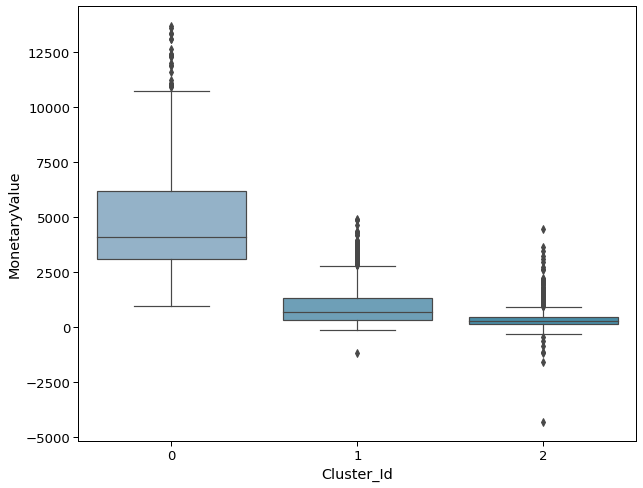

In [52]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='MonetaryValue', data=retail_rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

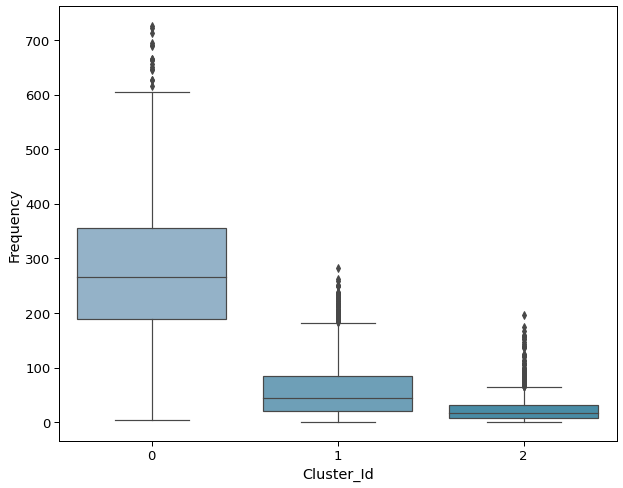

In [53]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=retail_rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

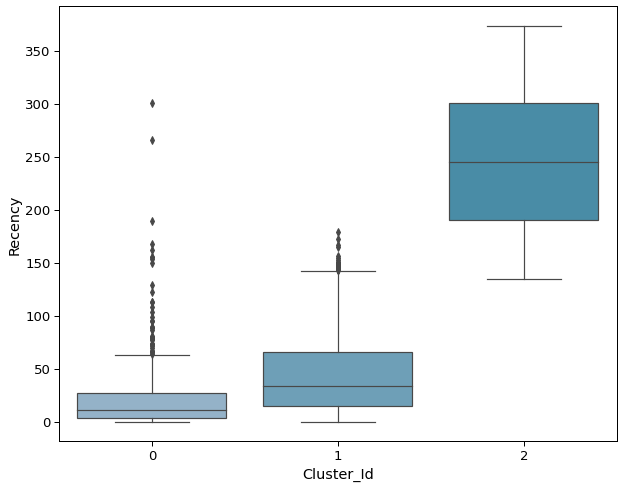

In [54]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=retail_rfm)

# DBSCAN Algorithm

In [72]:
retail_rfm.columns

Index(['CustomerID', 'MonetaryValue', 'Frequency', 'Recency', 'R', 'F', 'M',
       'RFM_Segment', 'RFM_Score', 'RFM_Level', 'Segment', 'Cluster_Id'],
      dtype='object')

In [73]:
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id
0,12346.0,0.00,2,325,1,1,1,111,3,Green,others,2
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold,Best Customers,0
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver,others,1
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver,Big Spenders,1
4,12350.0,334.40,17,309,1,1,2,112,4,Green,others,2


In [75]:
retail_rfm_new = retail_rfm[['CustomerID','MonetaryValue','Frequency','Recency']]
retail_rfm_new.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [77]:
retail_rfm_new.shape

(4295, 4)

In [85]:
scaled_df = scaler.fit_transform(retail_rfm_new) 
  
# Normalizing the Data 
normalized_df = sklearn.preprocessing.normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

normalized_df.describe()

,0,1,2,3
count,4295.000000,4295.000000,4295.000000,4295.000000
mean,0.001409,-0.103522,-0.099811,-0.079704
std,0.596098,0.390212,0.414468,0.542043
min,-0.999308,-0.941916,-0.924374,-0.995246
25%,-0.554231,-0.369476,-0.387429,-0.486885
50%,0.002466,-0.230053,-0.234697,-0.254454
75%,0.565457,0.101802,0.144000,0.392635
max,0.997465,0.991029,0.981718,0.984787


In [87]:
from sklearn.cluster import Birch
birch_cluster= Birch(n_clusters=3)
birch_cluster.fit(normalized_df)
labels=birch_cluster.labels_

birch_clusters=pd.concat([retail_rfm, pd.DataFrame({'birch_cluster':labels})], axis=1)
birch_clusters.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id,birch_cluster
0,12346.0,0.00,2.0,325.0,1,1,1,111,3.0,Green,others,2.0,2.0
1,12347.0,4310.00,182.0,1.0,4,4,4,444,12.0,Gold,Best Customers,0.0,1.0
2,12348.0,1797.24,31.0,74.0,2,2,4,224,8.0,Silver,others,1.0,0.0
3,12349.0,1757.55,73.0,18.0,3,3,4,334,10.0,Silver,Big Spenders,1.0,0.0
4,12350.0,334.40,17.0,309.0,1,1,2,112,4.0,Green,others,2.0,2.0
